# STM Transit Delay Data Preprocessing

## Overview

This notebook preprocesses data about STM trip updates weather and traffic, data in order to build a regression and classification model that predicts delays in seconds.

## Data Description

`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`route_type`: Type of bus line (e.g. Night).<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_name`: Name of the stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`stop_sequence`: Sequence of the stop, for ordering.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 (first stop) to 1 (last stop).<br>
`stop_has_alert`: Indicates if there's a message about the stop being moved or cancelled.<br>
`schedule_relationship`: State of the schedule: "scheduled", "skipped" or "no data".
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`rt_arrival_time`, `rt_departure_time`, `sch_arrival_time`, `sch_departure_time`: Realtime and scheduled times, in UTC.<br>
`delay`: Difference between real and scheduled arrival time, in seconds<br>
`delay_class`: Delay category, from early to late<br>
`incident_count`: Number of incidents within 500 meters of the stop.<br>
`incident_nearby`: Indicates if an incident happened within 500 meters of the stop.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`dew_point`: Dew point temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`wind_gusts`: Gusts at 10 meters above ground as a maximum of the preceding hour.<br>

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import DELAY_CLASS, LOCAL_TIMEZONE, OCCUPANCY_STATUS

In [3]:
# Load data
df = pd.read_parquet('../data/stm_weather_traffic_merged.parquet')

## Data Preprocessing

### Handle Delay Outliers

In [4]:
df['delay'].describe()

count    1.465192e+06
mean     6.487390e+01
std      3.676514e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      1.087847e+01
max      5.458500e+04
Name: delay, dtype: float64

In [5]:
# Compute mean and standard deviation
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

In [6]:
# Filter outliers based on standard deviation
outlier_mask = (df['delay'] < mean_delay - 3 * std_delay) | (df['delay'] > mean_delay + 3 * std_delay)

In [7]:
# Get proportion of outliers
print(f'{outlier_mask.mean():.2%}')

0.73%


In [8]:
# Remove outliers
df = df[~outlier_mask].reset_index(drop=True)

In [9]:
# Get new distribution
df['delay'].describe()

count    1.454541e+06
mean     5.267683e+01
std      1.442700e+02
min     -1.037000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      6.000000e+00
max      1.167000e+03
Name: delay, dtype: float64

### Encode Datetime

In [10]:
# Convert scheduled arrival time
df['sch_arrival_time'] = pd.to_datetime(df['sch_arrival_time'], utc=True).dt.tz_convert(LOCAL_TIMEZONE)

In [11]:
# Convert datetime to day and hour
df['day_of_week'] = df['sch_arrival_time'].dt.day_of_week
df['hour'] = df['sch_arrival_time'].dt.hour

In [12]:
# Convert hour to time of day
def time_of_day(hour):
  if 5 <= hour < 10:
    return 'morning'
  elif 10 <= hour < 15:
    return 'midday'
  elif 15 <= hour < 20:
    return 'evening'
  else:
    return 'night'

df['time_of_day'] = df['hour'].apply(time_of_day)

In [13]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['time_of_day'], drop_first=True, dtype='int64', prefix='time_of_day')
df = df.join(one_hot).drop('time_of_day', axis=1)

In [15]:
# Add boolean value is_weekend
weekend_mask = df['day_of_week'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [16]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

In [17]:
# Drop unneeded time-related columns
df = df.drop(['rt_arrival_time', 'rt_departure_time', 'sch_arrival_time', 'sch_departure_time', 'hour'], axis=1)

### Use Label Encoding for vehicle_id

### Use Ordinal Encoding for delay_class and occupancy_status

In [18]:
delay_map = {value: key for (key, value) in DELAY_CLASS.items()}
df['delay_class'] = df['delay_class'].map(delay_map).astype('int64')
df['delay_class'].value_counts(normalize=True)

delay_class
1    0.865496
2    0.118283
0    0.016222
Name: proportion, dtype: float64

In [19]:
occ_map = {value: key for (key, value) in OCCUPANCY_STATUS.items()}
df['occupancy_status'] = df['occupancy_status'].map(occ_map)
df['occupancy_status'].value_counts(normalize=True)

occupancy_status
1    0.455565
2    0.317043
3    0.211157
5    0.015513
0    0.000722
Name: proportion, dtype: float64

### Use One Hot Encoding for trip_progress, route_type and schedule_relationship

In [20]:
df['route_type'].value_counts()

route_type
Day                         818129
Rush Hour High Frequency    372800
All Day High Frequency      234448
Night                        29164
Name: count, dtype: int64

In [21]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['route_type'], drop_first=True, dtype='int64', prefix='route_type')
df = df.join(one_hot).drop('route_type', axis=1)

In [22]:
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled    1440979
Skipped         7639
No Data         5923
Name: count, dtype: int64

In [23]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['schedule_relationship'], drop_first=True, dtype='int64', prefix='sch_rel')
df = df.join(one_hot).drop('schedule_relationship', axis=1)

In [24]:
# Create buckets for trip_progress
ranges = [0, 0.33, 0.66, 1.0]
labels = ['start', 'middle', 'end']

df['trip_phase'] = pd.cut(df['trip_progress'], bins=ranges, labels=labels, include_lowest=True, right=False)
df['trip_phase'].value_counts(normalize=True)

trip_phase
end       0.374828
middle    0.323197
start     0.301975
Name: proportion, dtype: float64

In [25]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['trip_phase'], drop_first=True, dtype='int64', prefix='trip_phase')
df = df.join(one_hot).drop(['trip_progress', 'trip_phase'], axis=1)

### Drop redundant/unnecessary columns


In [26]:
# Get remaining string columns
df.select_dtypes(include='object').columns

Index(['stop_name'], dtype='object')

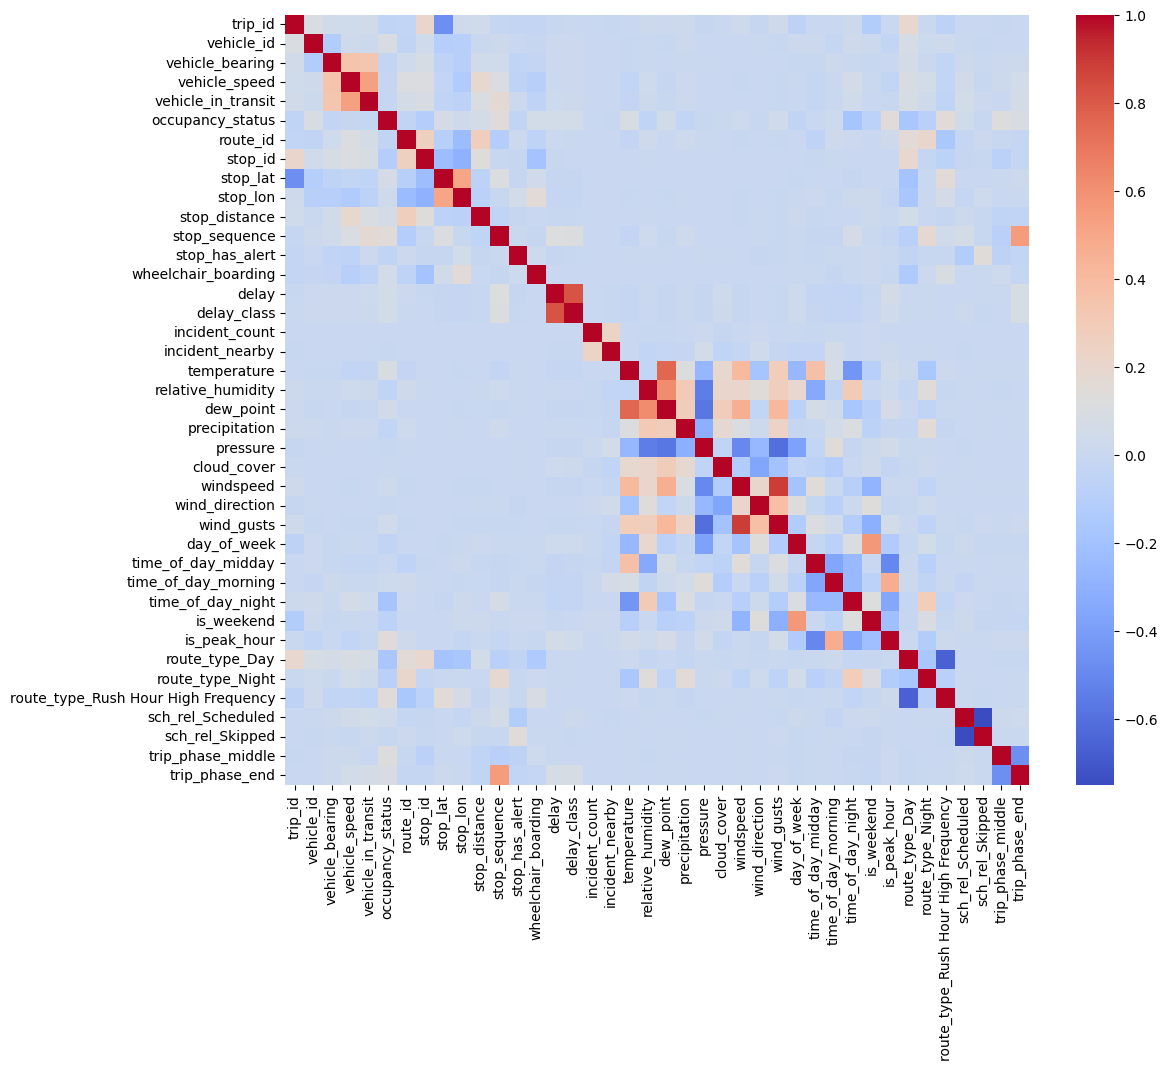

In [ ]:
# Look for correlated features
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [ ]:
# Combine wind features
df['wind_severity'] = df['windspeed'] * df['wind_gusts']

**Columns to drop**

`trip_id`: Identifies a vehicle on a specific day and might cause data leakage.<br>
`vehicle_id`: A unique identifier won't help make predictions.<br>
`route_id`: The route types have been encoded.<br>
`stop_id`, `stop_name`: The stop is already encoded with the coordinates.<br>
`stop_sequence`: The trip phases has been calculated.<br>
`windspeed`, `wind_gusts`: It has been replaced by wind severity.

In [ ]:
df = df.drop([
  	'trip_id',
    'vehicle_id',
  	'route_id',
  	'stop_id',
  	'stop_name',
  	'stop_sequence',
    'windspeed',
    'wind_gusts'
  ], axis=1)

## Export Data

In [29]:
df.columns

Index(['vehicle_bearing', 'vehicle_speed', 'vehicle_in_transit',
       'occupancy_status', 'stop_lat', 'stop_lon', 'stop_distance',
       'stop_has_alert', 'wheelchair_boarding', 'delay', 'delay_class',
       'incident_count', 'incident_nearby', 'temperature', 'relative_humidity',
       'dew_point', 'precipitation', 'pressure', 'cloud_cover', 'windspeed',
       'wind_direction', 'wind_gusts', 'day_of_week', 'time_of_day_midday',
       'time_of_day_morning', 'time_of_day_night', 'is_weekend',
       'is_peak_hour', 'route_type_Day', 'route_type_Night',
       'route_type_Rush Hour High Frequency', 'sch_rel_Scheduled',
       'sch_rel_Skipped', 'trip_phase_middle', 'trip_phase_end'],
      dtype='object')

In [ ]:
# Reorder columns
df = df[[
    	'vehicle_bearing',
    	'vehicle_speed',
    	'vehicle_in_transit',
       	'occupancy_status',
        'route_type_Day',
       	'route_type_Night',
    	'route_type_Rush Hour High Frequency',
		'stop_lat',
		'stop_lon',
		'stop_distance',
		'trip_phase_middle',
    	'trip_phase_end',
    	'stop_has_alert',
      	'wheelchair_boarding',
		'sch_rel_Scheduled',
       	'sch_rel_Skipped',
		'day_of_week',
    	'time_of_day_midday',
    	'time_of_day_morning',
       	'time_of_day_night',
    	'is_weekend',
       	'is_peak_hour',
		'incident_count',
		'incident_nearby',
    	'temperature',
    	'relative_humidity',
       	'dew_point',
    	'precipitation',
    	'pressure',
    	'cloud_cover', 
    	'wind_severity',
       	'wind_direction',
    	'delay',
       	'delay_class',
]]

In [31]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [32]:
# Export dataframe
df.to_parquet('../data/preprocessed.parquet', index=False)

## End